# Multiclass Classification using Logistic Regression and Deep Learning

I have collected 2855 datapoints from BTC/USD using yfinance to collect historical prices and then calculated several technical indicators from those prices using pandas_ta. Let's download that data.

In [384]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

conn = sqlite3.connect('btc_usd_short_and_long.sqlite')
df = pd.read_sql_query("SELECT * from prices", conn)



Here we can see the data. There's missing values because all the technical indicators are calculated using several values of the prices, so e.g. rsi starts after 14 "close" -prices because of the way it's calculated. We will have to address those missing values of course. The target is when the price has risen over 10% in the last 5 days. We will modify this to be a projection of the future. 

My plan is to make 10 new lagged features of all the technical indicators. So the model can actually use 10 previous data points instead of just one. Let's make those features first.

In [385]:
def make_lags(name, feature, lags):
    return pd.concat(
    {
        f'{name}_lag_{i}': feature.shift(i)
        for i in range(1, lags + 1)
    },
    axis = 1)

df = df.join(make_lags("pricechg", df.price_chg, lags=10))
df = df.join(make_lags("highperc", df.high_perc, lags=10))
df = df.join(make_lags("lowperc", df.low_perc, lags=10))
df = df.join(make_lags("rsi", df.rsi, lags=10))

Okay now we got all the lagged features. Then because we want to target to be 5 days in the future, we need to shift the target back 5 days so we can get it in the right row.

In [386]:
df['target'] = df['target'].shift(-10)

In [387]:
df.target

0       2.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2859    NaN
2860    NaN
2861    NaN
2862    NaN
2863    NaN
Name: target, Length: 2864, dtype: float64

All right great! Now we just have to address the missing values. We will drop all the missing values which is going to align the columns accordingly.

In [388]:
df.dropna(inplace=True)
df.target

27      2.0
28      0.0
29      0.0
30      0.0
31      2.0
       ... 
2848    0.0
2849    0.0
2850    0.0
2851    0.0
2852    1.0
Name: target, Length: 2826, dtype: float64

Let's plot the data first so we know there's nothing wrong here.

## Now the data is processed, amazing! Now we can actually start modeling!

The target is a two-categorical variable: either the price is going to rise over 10% in the next 5 datapoints, which is marked as 1, or it is not which is marked as 0. So this model is going to be a binary classifier.

Let's split the data into train and test sets.

In [389]:
from keras.utils import to_categorical

X = df.drop(["name", "target", "date", "id", "close", "low", "high", "slowk", "slowd", "adx", "dmp", "dmn"], axis=1)
y = df["target"]

In [390]:
X

,high_perc,low_perc,price_chg,rsi,pricechg_lag_1,pricechg_lag_2,pricechg_lag_3,pricechg_lag_4,pricechg_lag_5,pricechg_lag_6,...,rsi_lag_1,rsi_lag_2,rsi_lag_3,rsi_lag_4,rsi_lag_5,rsi_lag_6,rsi_lag_7,rsi_lag_8,rsi_lag_9,rsi_lag_10
27,-2.701126,2.381318,2.899003,56.293392,-2.607091,-9.318688,-4.328089,-2.277696,-0.867800,2.966060,...,52.739806,48.311573,41.319059,40.982820,42.033997,36.780528,28.431847,25.082401,19.609190,20.843957
28,-1.888168,1.521639,1.816846,53.755190,2.899003,-2.607091,-9.318688,-4.328089,-2.277696,-0.867800,...,56.293392,52.739806,48.311573,41.319059,40.982820,42.033997,36.780528,28.431847,25.082401,19.609190
29,-4.248007,2.479635,4.746696,48.988694,1.816846,2.899003,-2.607091,-9.318688,-4.328089,-2.277696,...,53.755190,56.293392,52.739806,48.311573,41.319059,40.982820,42.033997,36.780528,28.431847,25.082401
30,-0.448199,2.180798,3.310997,49.463490,4.746696,1.816846,2.899003,-2.607091,-9.318688,-4.328089,...,48.988694,53.755190,56.293392,52.739806,48.311573,41.319059,40.982820,42.033997,36.780528,28.431847
31,-0.949311,3.185907,-0.958062,52.506761,3.310997,4.746696,1.816846,2.899003,-2.607091,-9.318688,...,49.463490,48.988694,53.755190,56.293392,52.739806,48.311573,41.319059,40.982820,42.033997,36.780528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2848,-2.205790,4.204448,-1.407329,36.788160,-2.259173,1.258847,0.686613,5.211297,-3.620190,0.536250,...,36.980508,29.173371,28.692001,28.781832,30.465463,31.526433,32.100613,33.562404,34.498310,36.016475
2849,-0.230108,3.526989,-2.242749,39.726712,-1.407329,-2.259173,1.258847,0.686613,5.211297,-3.620190,...,36.788160,36.980508,29.173371,28.692001,28.781832,30.465463,31.526433,32.100613,33.562404,34.498310
2850,-0.620349,6.199787,-0.878487,47.692137,-2.242749,-1.407329,-2.259173,1.258847,0.686613,5.211297,...,39.726712,36.788160,36.980508,29.173371,28.692001,28.781832,30.465463,31.526433,32.100613,33.562404
2851,-2.686582,2.179658,-1.613855,48.323595,-0.878487,-2.242749,-1.407329,-2.259173,1.258847,0.686613,...,47.692137,39.726712,36.788160,36.980508,29.173371,28.692001,28.781832,30.465463,31.526433,32.100613


In [391]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=42)

In [392]:
X_train.columns

Index(['high_perc', 'low_perc', 'price_chg', 'rsi', 'pricechg_lag_1',
       'pricechg_lag_2', 'pricechg_lag_3', 'pricechg_lag_4', 'pricechg_lag_5',
       'pricechg_lag_6', 'pricechg_lag_7', 'pricechg_lag_8', 'pricechg_lag_9',
       'pricechg_lag_10', 'highperc_lag_1', 'highperc_lag_2', 'highperc_lag_3',
       'highperc_lag_4', 'highperc_lag_5', 'highperc_lag_6', 'highperc_lag_7',
       'highperc_lag_8', 'highperc_lag_9', 'highperc_lag_10', 'lowperc_lag_1',
       'lowperc_lag_2', 'lowperc_lag_3', 'lowperc_lag_4', 'lowperc_lag_5',
       'lowperc_lag_6', 'lowperc_lag_7', 'lowperc_lag_8', 'lowperc_lag_9',
       'lowperc_lag_10', 'rsi_lag_1', 'rsi_lag_2', 'rsi_lag_3', 'rsi_lag_4',
       'rsi_lag_5', 'rsi_lag_6', 'rsi_lag_7', 'rsi_lag_8', 'rsi_lag_9',
       'rsi_lag_10'],
      dtype='object')

We will try how a simple logistic regression would fit our data.

In [393]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [394]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=100000)
model.fit(X_train_scaled, y_train)
y_hat_train = model.predict(X_train_scaled)
y_hat_test = model.predict(X_test_scaled)

0.6582406471183013
0.6155660377358491


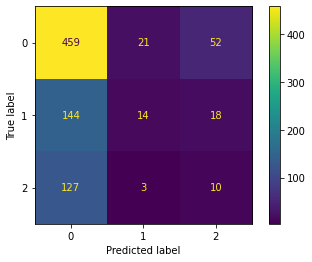

In [395]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print(precision_score(y_train, y_hat_train, average='micro'))
print(precision_score(y_test, y_hat_test, average='micro'))

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [396]:
import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.regularizers import l2
from keras.layers.core import Dropout
from keras.wrappers.scikit_learn import KerasClassifier

In [397]:
%%capture
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

opt = Adam(learning_rate=0.001)

model = keras.models.Sequential([
    keras.layers.Dense(35, activation='relu', input_dim=44, kernel_regularizer=regularizers.L2(0.01)),
    keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['Accuracy'])
res = model.fit(X_train_scaled, y_train, validation_data = (X_test_scaled, y_test), epochs=30, shuffle=False)

In [398]:
import numpy as np

y_pred = np.argmax(model.predict(X_train_scaled), axis=1)
y_test_pred = np.argmax(model.predict(X_test_scaled), axis=1)
y_test = np.argmax(y_test, axis=1)

27/27 [==============================] - 0s 948us/step


Our model is doing better than the logistic regression, that's good news. But the model is clearly overfitting the data. We need to either add more data or regularize our model.

Text(0, 0.5, 'Loss')

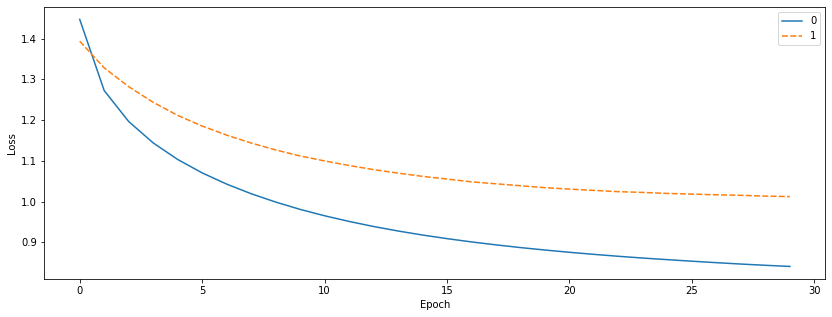

In [399]:
plt.figure(figsize=(14,5))
sns.lineplot(data=(res.history['loss'], res.history['val_loss']))
plt.xlabel('Epoch')
plt.ylabel('Loss')

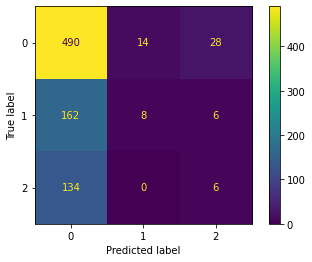

In [400]:
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()